# Plot topography

In [2]:
from eval_functions import *
import valenspy as vp
from valenspy.diagnostic_visualizations import *


import xarray as xr
from pathlib import Path
import cdo 
from yaml import safe_load
import os

from valenspy.preprocessing_tasks.regrid import remap_cdo
import warnings

# Turn off all warnings
warnings.filterwarnings('ignore')

# define machine name - used for paths of (observational) datasets
machine = 'hortense'

# postprocessing base directory 
postproc_base_dir = "/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/"

src_path = Path("../src/valenspy")

experiments = ["EUR11_CO_TA_GC_TSO"]

In [3]:

# reference dataset to compare to
model = 'CCLM'

# get lookup file for model
with open(src_path / "ancilliary_data" / Path(model+"_lookup.yml")) as file:
    mod_LOOKUP = safe_load(file)

ref_dataset = "ERA5"


# secondary list of variables to compare
# cloud characteristics (integrated cloud water, ice, graupel, snow and rain) (NOT YET IN CORDEX_VARIABLES list)
# ERA5-land: surface fluxes: latent heat, sensible heat

In [4]:
# define bounds 
bounds = {'europe':
                    {'lat_bounds': [70,35], 
                    'lon_bounds': [-15,40]}, 
        'belgium': 
                    {'lat_bounds': [52,49], 
                    'lon_bounds': [2,7]}}

In [5]:
## OROGRAPHY
# load orography of ERA5 and select point
orography_era5_file = '/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/fx/era5-orography.nc'
ds_orography_era5 = xr.open_mfdataset(orography_era5_file, combine="by_coords", chunks="auto")

# Earth gravitational acceleration
g = 9.80665 # m s-2
# calculate orography (m) by dividing the surface geopotential height by the Earth gravitational acceleration
da_obs_topography = (ds_orography_era5["z"] / g).squeeze().rename({'latitude' : 'lat', 'longitude' : 'lon'})
da_obs_topography.attrs['dataset'] = ref_dataset
da_obs_topography.attrs['long_name'] = 'Altitude'
da_obs_topography.attrs['units'] = 'm above sea level'

## load orography of CCLM and select point 
# define the path
directory = Path(postproc_base_dir + experiments[0] +'/')
# define the CCLM files for the corresponding variable
cst_file = list(directory.glob("*c.nc")) # Select all the netCDF files in the directory
ds_mod_cst = xr.open_mfdataset(cst_file, combine="by_coords", chunks="auto")

# do remapping
# retrieve ERA5 gridfile - for regridding 
gridfile = orography_era5_file

# do regridding 
ds_mod_cst_regrid = remap_cdo(gridfile, ds_mod_cst, remap_method="con")

# get altitude

da_mod_topography = ds_mod_cst_regrid["HSURF"]
da_mod_topography.attrs['dataset'] = experiments[0]

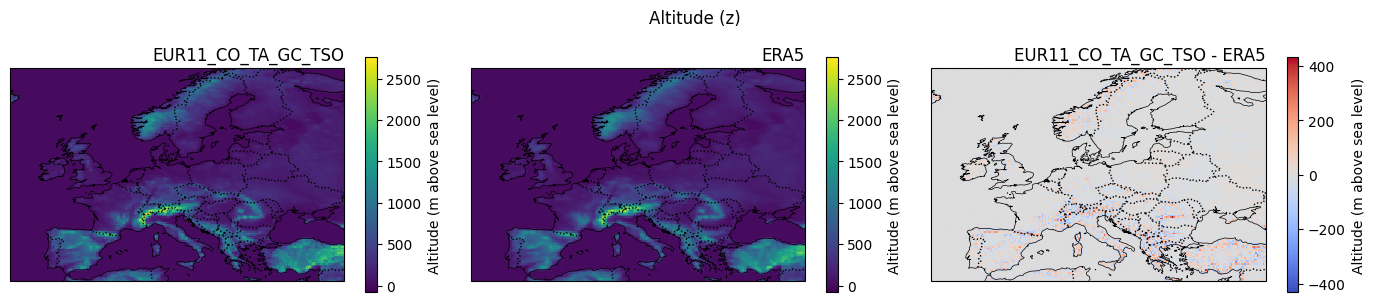

In [6]:
region = 'europe'

lat_bounds = bounds[region]['lat_bounds']
lon_bounds = bounds[region]['lon_bounds']

da_mod_topography = da_mod_topography.sel(lon=slice(lon_bounds[0],lon_bounds[1]),lat=slice(lat_bounds[0], lat_bounds[1]))
da_obs_topography = da_obs_topography.sel(lon=slice(lon_bounds[0],lon_bounds[1]),lat=slice(lat_bounds[0], lat_bounds[1]))


diff = da_mod_topography -  da_obs_topography
fig = plot_maps_mod_ref_diff(da_mod_topography,  da_obs_topography,  diff)

In [7]:
da_mod_topography

<xarray.DataArray 'HSURF' (time: 1, lat: 141, lon: 221)> Size: 125kB
dask.array<getitem, shape=(1, 141, 221), dtype=float32, chunksize=(1, 141, 221), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 8B 1995-05-01
  * lon      (lon) float32 884B -15.0 -14.75 -14.5 -14.25 ... 39.5 39.75 40.0
  * lat      (lat) float32 564B 70.0 69.75 69.5 69.25 ... 35.75 35.5 35.25 35.0
Attributes:
    standard_name:  surface_altitude
    long_name:      surface height
    units:          m
    cell_methods:   time: point
    dataset:        EUR11_CO_TA_GC_TSO

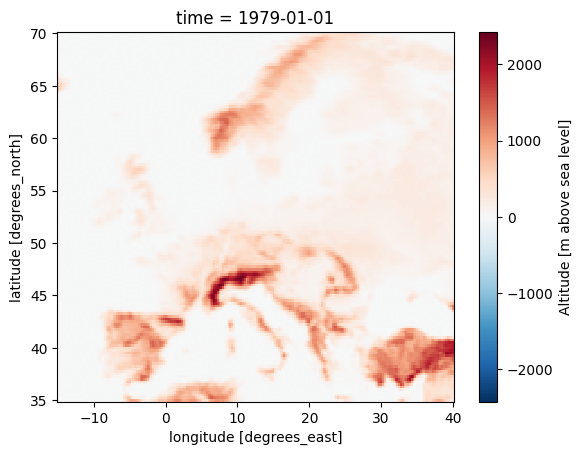

In [10]:
da_obs_topography.plot()

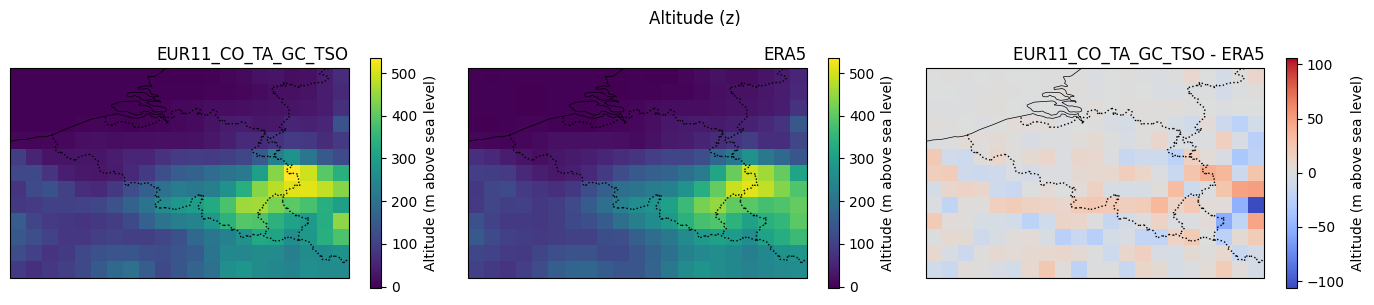

: 

In [22]:
region = 'belgium'

lat_bounds = bounds[region]['lat_bounds']
lon_bounds = bounds[region]['lon_bounds']

da_mod_topography = da_mod_topography.sel(lon=slice(lon_bounds[0],lon_bounds[1]),lat=slice(lat_bounds[0], lat_bounds[1]))
da_obs_topography = da_obs_topography.sel(lon=slice(lon_bounds[0],lon_bounds[1]),lat=slice(lat_bounds[0], lat_bounds[1]))

diff = da_mod_topography -  da_obs_topography
fig = plot_maps_mod_ref_diff(da_mod_topography,  da_obs_topography,  diff)